In [1]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


### 1. Exploratory Data Analysis

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("/ibex/scratch/qunberas/dataset_chest/train")
img_as_jpg = list(path.glob(r"*/*.jpeg"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_as_jpg))
normal = file_count.count('NORMAL')
pneumonia = file_count.count('PNEUMONIA')

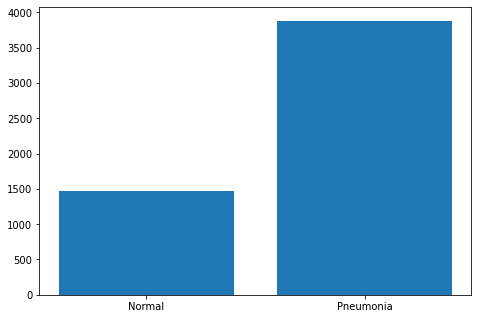

In [3]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Normal','Pneumonia']
count_train = [normal, pneumonia]
ax.bar(labels, count_train)
plt.show()

In [4]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(5349, 2)


In [5]:
# test
path = Path("/ibex/scratch/qunberas/dataset_chest/test")
img_as_jpg = list(path.glob(r"*/*.jpeg"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_as_jpg))

test = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
test = test.sample(frac=1).reset_index(drop=True)
print(np.shape(test))

(507, 2)


In [6]:
train = train.append(test, ignore_index=True)

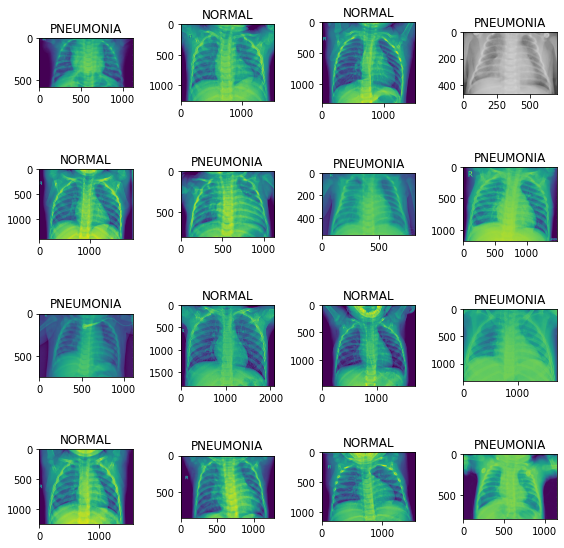

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1): 
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

## 2. Model

In [8]:
# hparams = AttrDict(
#     image_size=(128, 128, 3),
#     n_classes=len(labels),
#     batch_size=64,
# )

# ds = tf.keras.preprocessing.image_dataset_from_directory("/ibex/scratch/qunberas/dataset_chest/train", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
# train_split = round(0.8 * ds.cardinality().numpy()) 
# train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
# validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

In [9]:
!nvidia-smi

Mon Jul  5 12:05:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla V1...  On   | 00000000:88:00.0 Off |                    0 |
| N/A   29C    P0    40W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Tesla V1...  On   | 00000000:89:00.0 Off |                    0 |
| N/A   

In [10]:
## train_test structure
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=len(labels),
    batch_size=64,
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory("/ibex/scratch/qunberas/dataset_chest/train", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory("/ibex/scratch/qunberas/dataset_chest/test", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)

 

Found 5349 files belonging to 2 classes.
Found 507 files belonging to 2 classes.


In [11]:
train_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

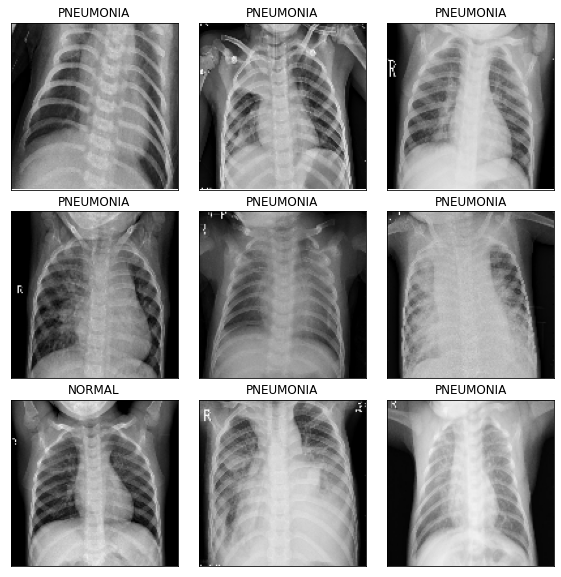

In [12]:
_ = plot_grid_ds(train_ds)

In [13]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow

In [14]:
model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/repl

## 3. Results

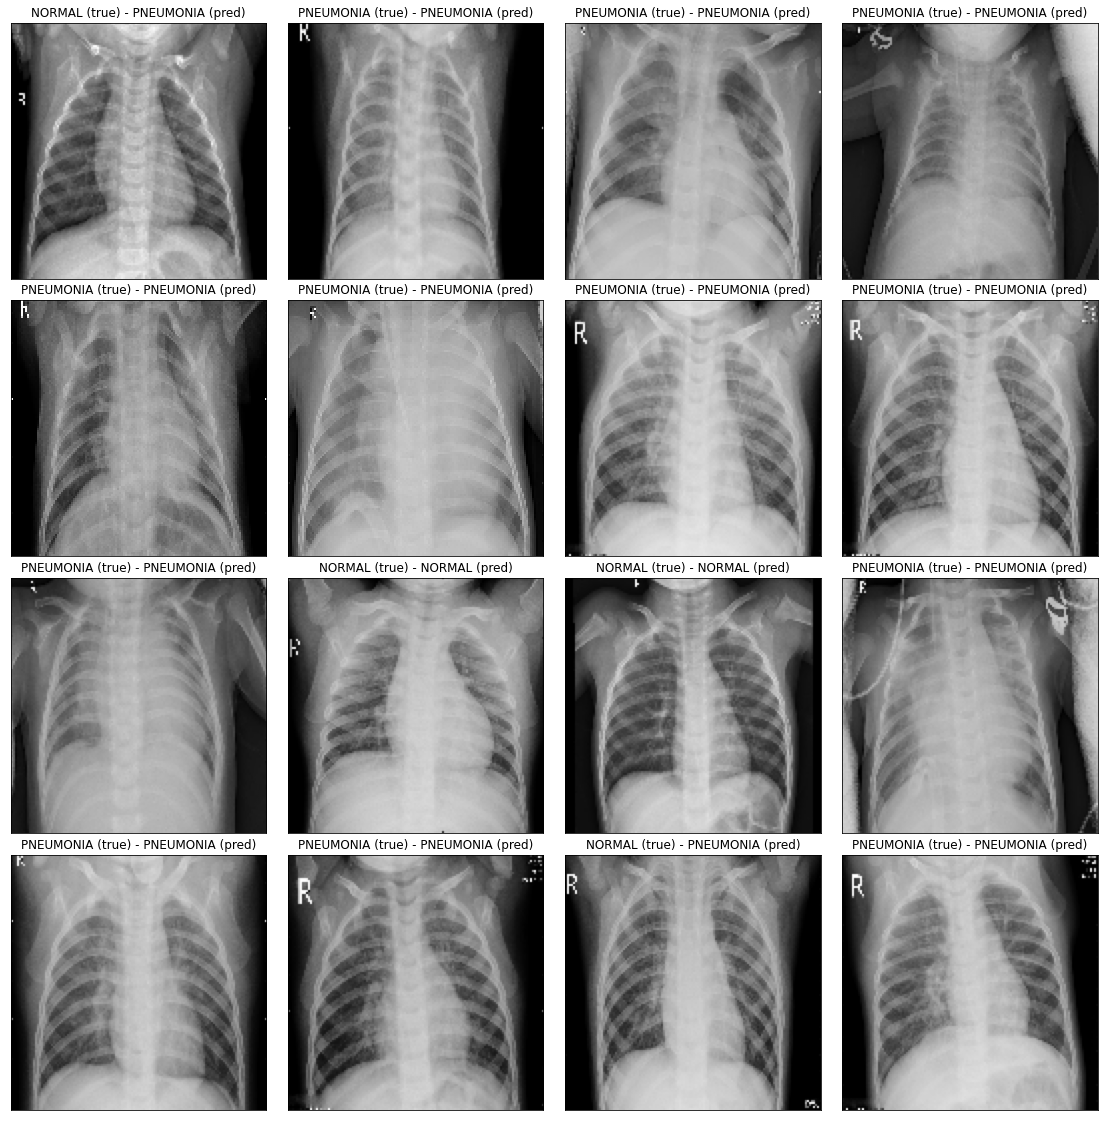

In [15]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [16]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

array([[ 50,  67],
       [  6, 384]])

In [17]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.706


In [18]:
model.save("models/ViT_on_10_epochs.model")

INFO:tensorflow:Assets written to: models/ViT_on_10_epochs.model/assets


INFO:tensorflow:Assets written to: models/ViT_on_10_epochs.model/assets
